### Uncovering Workforce Diversity Clusters Across Tech Companies: An Unsupervised Learning Approach

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file_url = "https://raw.githubusercontent.com/Moyoshabz/Diversity_Clustering_Analysis/main/diversity.csv"
df = pd.read_csv(file_url)

In [3]:
df.head()

,Year,Company,Female %,Male %,% White,% Asian,% Latino,% Black,% Multi,% Other,% Undeclared
0,2018,Yahoo!,37,63,45,44,4,2,2,3,-
1,2018,Google,31,69,53,36,4,3,4,0,-
2,2018,Apple,32,68,54,21,13,9,3,1,2
3,2018,Cisco,24,76,53,37,5,4,1,<1,-
4,2018,eBay,40,60,50,39,6,3,1,1,-


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Year          94 non-null     int64 
 1   Company       94 non-null     object
 2   Female %      94 non-null     int64 
 3   Male %        94 non-null     int64 
 4   % White       94 non-null     int64 
 5   % Asian       94 non-null     object
 6   % Latino      94 non-null     object
 7   % Black       94 non-null     object
 8   % Multi       94 non-null     object
 9   % Other       93 non-null     object
 10  % Undeclared  94 non-null     object
dtypes: int64(4), object(7)
memory usage: 8.2+ KB


In [5]:
#Checking for NaNs
nan_rows = df[df.isnull().any(axis=1)]
print(nan_rows)

    Year Company  Female %  Male %  % White % Asian % Latino % Black % Multi  \
54  2016   Etsy         51      49       79      11        4       3       3   

   % Other % Undeclared  
54     NaN            -  


### Data Cleaning and preprocessing

In [6]:
# Cleaning and convert percentage columns in the dataset
percent_cols = ['% Asian', '% Latino', '% Black', '% Multi', '% Other', '% Undeclared']

for col in percent_cols:
    # Replace all the '-' with NaN, then strip '%', then convert to float
    df[col] = df[col].replace('-', np.nan)
    df[col] = df[col].astype(str).str.replace('%', '', regex=False).str.strip()
    df[col] = pd.to_numeric(df[col], errors='coerce')


In [7]:
# Impute missing values in percentage columns with 0
df[percent_cols] = df[percent_cols].fillna(0)

### EDA

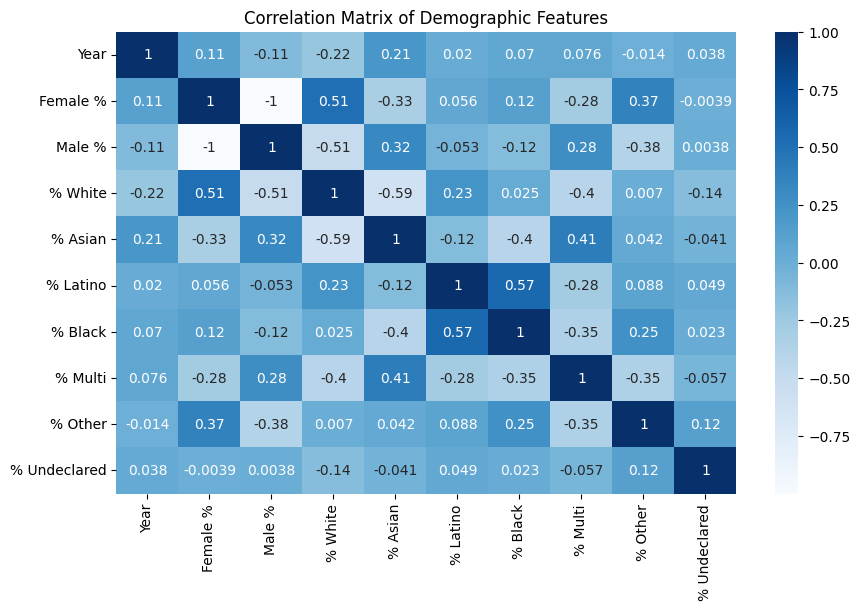

In [9]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, cmap='Blues')
plt.title('Correlation Matrix of Demographic Features')
plt.show()

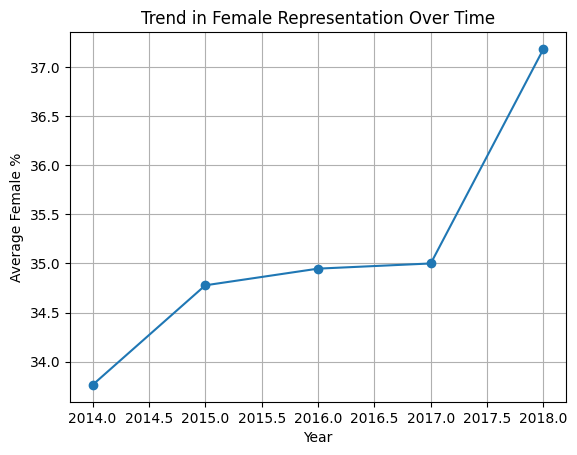

In [11]:
# Example: Average Female % per year
trend = df.groupby('Year')['Female %'].mean().reset_index()

plt.plot(trend['Year'], trend['Female %'], marker='o')
plt.title('Trend in Female Representation Over Time')
plt.xlabel('Year')
plt.ylabel('Average Female %')
plt.grid(True)
plt.show()

### Feature Engineering

In [12]:
#Creating a new column called gender
df['Gender Imbalance'] = abs(df['Female %'] - df['Male %'])

In [13]:
ethnicity_cols = ['% White', '% Asian', '% Latino', '% Black', '% Multi', '% Other', '% Undeclared']
df['Ethnicity Total'] = df[ethnicity_cols].sum(axis=1)
df[ethnicity_cols] = df[ethnicity_cols].div(df['Ethnicity Total'], axis=0) * 100

In [16]:
# Shannon Diversity Index
def shannon_entropy(row):
    proportions = row.values.astype(float) / 100
    proportions = proportions[~np.isnan(proportions)]
    proportions = proportions[proportions > 0]
    return -np.sum(proportions * np.log2(proportions))

In [17]:
ethnicity_cols = ['% White', '% Asian', '% Latino', '% Black', '% Multi', '% Other', '% Undeclared']
df['Shannon Diversity'] = df[ethnicity_cols].apply(shannon_entropy, axis=1)

In [20]:
df[['Company', 'Year', 'Shannon Diversity']].head(22)

,Company,Year,Shannon Diversity
0,Yahoo!,2018,1.602824
1,Google,2018,1.539336
2,Apple,2018,1.964243
3,Cisco,2018,1.484464
4,eBay,2018,1.557975
5,HP,2018,1.287167
6,Indiegogo,2018,1.576104
7,Nvidia,2018,1.664446
8,Dell,2018,1.430951
9,Ingram Micro,2018,1.806462


### Top 3 insights using the Shannon Index

1. Using 2018 as a case study, from the shannon diversity index calculated shows that Netflix(1.996), Apple(1.964), and Amazon(1.962) had the most diverse workforces

2. Etsy(1.124) and HP(1.287) had the least ethnic diversity

3. Streaming and tech-forward companies are lead the way in diversity, whereas traditional hardware or enterprise-focused companies like HP, Cisco, and Dell lag behind.

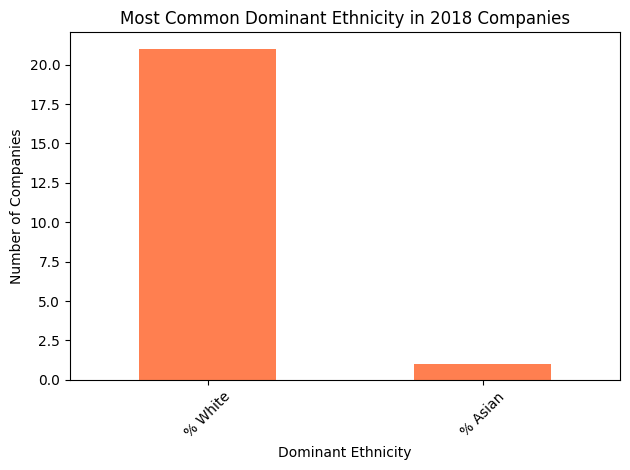

In [24]:

ethnicity_columns = ['% White', '% Asian', '% Latino', '% Black', '% Multi', '% Other']

for col in ethnicity_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Filtering for 2018
df_2018 = df[df['Year'] == 2018].copy()

df_melted = df_2018.melt(id_vars=['Company'], value_vars=ethnicity_columns,
                         var_name='Ethnicity', value_name='Percentage')

df_dominant = df_2018[['Company'] + ethnicity_columns].copy()
df_dominant['Dominant Ethnicity'] = df_dominant[ethnicity_columns].idxmax(axis=1)

dominant_counts = df_dominant['Dominant Ethnicity'].value_counts()

dominant_counts.plot(kind='bar', color='coral')
plt.title('Most Common Dominant Ethnicity in 2018 Companies')
plt.ylabel('Number of Companies')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [25]:
from sklearn.preprocessing import StandardScaler
features = ['Female %', 'Male %', 'Gender Imbalance', 'Shannon Diversity'] + ethnicity_cols

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

### K-Means Clustering

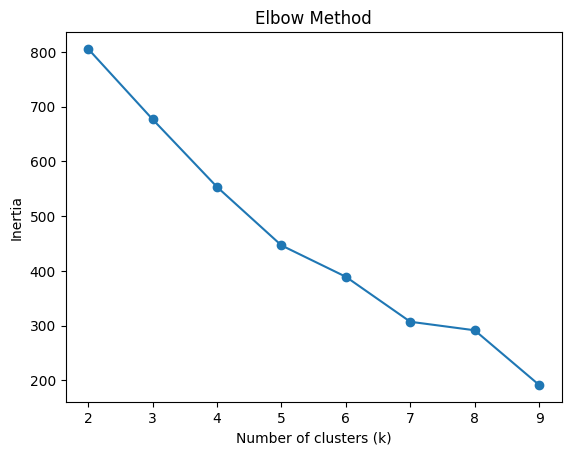

In [26]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Using the elbow method to choose the value of k
inertia = []
k_range = range(2, 10)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

### Insight
From the graph above our k is 5

In [27]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

In [32]:
#Understanding what each cluster mean
for i in range(5):
    print(f"\nCluster {i} Companies:")
    print(df[df['Cluster'] == i][['Company', 'Year']])


Cluster 0 Companies:
      Company  Year
6   Indiegogo  2018
11    Groupon  2018
13      Etsy   2018
16    Pandora  2018
18      Slack  2018
21       Yelp  2018
28  Indiegogo  2017
33    Groupon  2017
35      Etsy   2017
38    Pandora  2017
45       eBay  2016
47  Indiegogo  2016
52    Groupon  2016
54      Etsy   2016
57    Pandora  2016
64       eBay  2015
66  Indiegogo  2015
71    Groupon  2015
73      Etsy   2015
76    Pandora  2015
82       eBay  2014
84  Indiegogo  2014
89    Groupon  2014
92    Pandora  2014

Cluster 1 Companies:
       Company  Year
0       Yahoo!  2018
1       Google  2018
3        Cisco  2018
4         eBay  2018
5           HP  2018
10       Intel  2018
14   Microsoft  2018
15  Salesforce  2018
17        Uber  2018
19     AirBnB   2018
22      Yahoo!  2017
23      Google  2017
25       Cisco  2017
26        eBay  2017
27          HP  2017
32       Intel  2017
36   Microsoft  2017
37  Salesforce  2017
39        Uber  2017
40      Yahoo!  2016
41      Google 

### PCA Visualization

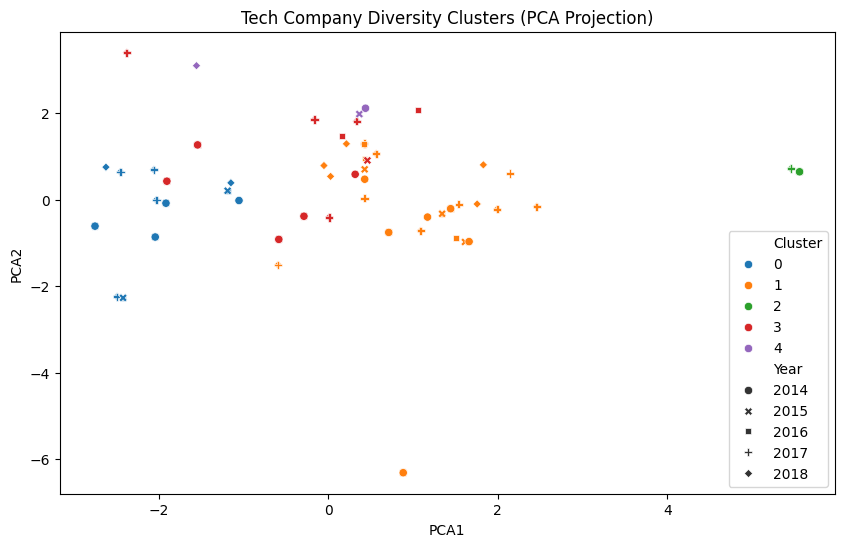

In [28]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
df['PCA1'] = pca_result[:, 0]
df['PCA2'] = pca_result[:, 1]

# Scatter plot
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Cluster', style='Year', palette='tab10')
plt.title('Tech Company Diversity Clusters (PCA Projection)')
plt.show()

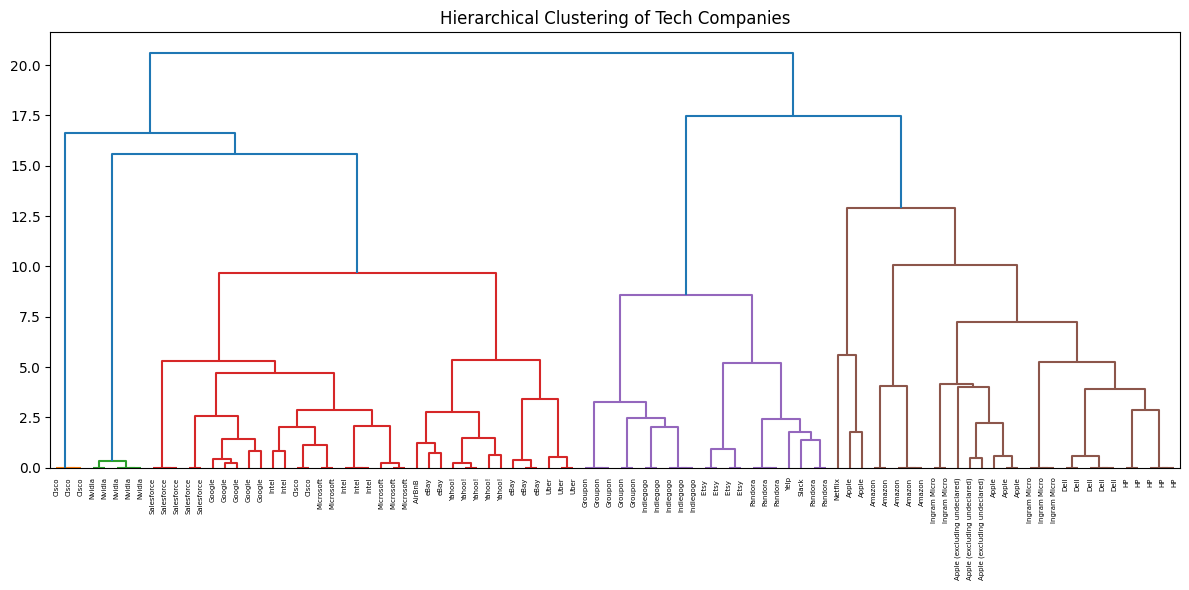

In [29]:
from scipy.cluster.hierarchy import linkage, dendrogram

linkage_matrix = linkage(X_scaled, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, labels=df['Company'].values, leaf_rotation=90)
plt.title('Hierarchical Clustering of Tech Companies')
plt.tight_layout()
plt.show()